# Sketch2aia - Abordagem com *Deep Learning*

Para a abordagem utilizando *Deep Learning*, se optou pela utilização do YoloV5 devido aos bons resultados obtidos anteriormente com YoloV3 e YoloV4, sua boa performance em geral e o baixo impacto de seus principais pontos fracos no problema em questão.


## YOLOv5

YOLO (*You Only Look Once*) é um algoritmo de detecção de objetos que divide a imagem em um sistema de grades, com cada célula na grade sendo responsável pela detecção de objetos dentro de si:

<img src="media/YoloDog.png" width=600/>

Desde sua criação, o modelo YOLO se tornou um dos modelos de detecção de objetos mais famosos, devido a sua velocidade e acurácia.

A equipe já havia realizado experimentos com YOLOv3 e YOLOv4, obtendo bons resultados, logo, foi decidido utilizar o YOLOv5, onde o modelo YOLO foi então introduzido ao framework PyTorch.

São disponibilizados diversos modelos de YOLOv5, com modelos mais simples focando em maior velocidade de processamento de imagens ou uso de memória, enquanto os modelos maiores tem maior foco em acurácia:

<img src="media/YoloModels.png" width=600/>

<img src="media/YoloModelsPerformance.png" width=600/>

Foram realizados testes com diversos modelos, com os melhores resultados sendo obtidos com o `YOLOv5m6`:

![Model Tests](media/YoloModelsTests.png)

## Conjunto de Dados

Para o treinamento do classificador, e para a realização de testes, foi preparado um conjunto de dados de *sketches* de interfaces de usuário, feitos com base em *screenshot* de aplicativos App Inventor:

| Screenshot                              | *Sketch*
| :-------------------------------------: | :--------------------------------------:
| <img src="media/ExampleScreenshot1.png" width=256/> | <img src="media/ExampleSketch1.jpg" width=256/>

Foram selecionados originalmente *screenshots* com apenas os 9 componentes mais comuns em aplicativos de App Inventor<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1), visando simplificar a tarefa de classificação destes, visto que outros componentes muito pouco utilizados são visualmente muito parecidos em *sketches*:

| Label                                   | Button                                   | TextBox
| :-------------------------------------: | :--------------------------------------: | :----:
| <img src="media/Label1.jpg" width=256/> | <img src="media/Botao1.jpg" width=256/>  | <img src="media/TextBox1.jpg" width=256/> 

| Checkbox                                | Slider                                   | ListPicker
| :-------------------------------------: | :--------------------------------------: | :----:
| <img src="media/Checkbox1.jpg" width=256/> | <img src="media/Slider1.jpg" width=256/> | <img src="media/ListPicker1.jpg" width=256/>

| Switch                                   | Image                                    | Map
| :-------------------------------------:  | :--------------------------------------: | :----:
| <img src="media/Switch1.jpg" width=256/> | <img src="media/Image1.jpg" width=256/>  | <img src="media/Map1.jpg" width=256/>

Com a ajuda de voluntários, foram coletados *sketches* com base nestes *screenshots* selecionados, gerando assim um conjunto de dados completo com diversos estilos de desenho e com variação de câmera e condições luminosas:

<table><tr>
    <td> <img src="media/ExampleSketch2.jpg" width=256/> </td>
    <td> <img src="media/ExampleSketch3.jpg" width=256/> </td>
    <td> <img src="media/ExampleSketch4.jpg" width=256/> </td>
</tr></table>

Os *sketches* feitos pelos voluntários foram então rotulados manualmente, com anotações de posição e tipo de cada componente, bem como a posição da tela (*screen*) como um todo:

<img src="media/Annotations.png" width=600/>

Resultando em um conjunto de dados com 402 imagens de *sketches* de interfaces de usuário, com anotações de 3584 componentes:

![Class Balance](media/ClassBalance2.png)

Estas foram divididas em conjuntos de treino, validação e testes com as seguintes proporções<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1):

![Split](media/Split2.png)

## Setup

Primeiramente, caso esteja executando este notebook no Google Colab, é necessário clonar o repositório para obter os arquivos necessários:

In [60]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  !git clone https://github.com/Dsbaule/INE410121-VisaoComputacional.git
  %cd ./INE410121-VisaoComputacional
  !git checkout adding-deep-learning

Um pequeno problema que encontramos, é que o arquivo de pesos tem 270MB... Utilizamos o git LFS para colocar o arquivo no repositório, porém encontramos problemas na hora de executar a rede utilizando este arquivo clonado do github.

Portanto, recomendamos remover o arquivo clonado e substituir por um baixado diretamente do OneDrive, o *snippet* de código a seguir realiza esta funcionalidade:

In [ ]:
# Git does not like the weights file, causing issues, so replace with download from onedrive
%cd ./yolov5m6/weights
!rm ./best.pt
!wget --no-check-certificate "https://onedrive.live.com/download?cid=726D6203EEAF5B92&resid=726D6203EEAF5B92%21431823&authkey=AD5Cj18ynPCmlCw" -O best.pt
%cd ../..

Agora, é possível clonar o repositório do YOLOv5:

In [1]:
# Clone YOLOv5 and install dependencies
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

# Import libs
import torch
import os
from IPython.display import Image, clear_output

# Check if cuda enabled
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

C:\Users\dsbau\OneDrive\Documents\UFSC\Mestrado\2oSemestre\INE410121-VisaoComputacional\INE410121-VisaoComputacional\yolov5


fatal: destination path 'yolov5' already exists and is not an empty directory.


Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'


Note: you may need to restart the kernel to use updated packages.
Setup complete. Using torch 1.10.2+cpu (CPU)


In [2]:
# Stops "RUN ALL"
assert(False)

C:\Users\dsbau\OneDrive\Documents\UFSC\Mestrado\2oSemestre\INE410121-VisaoComputacional\INE410121-VisaoComputacional\yolov5


## Treinando o Modelo

Com o conjunto de dados pronto e o ambiente configurado, é possível treinar o modelo YOLOv5

In [9]:
# Configure model
os.environ["MODEL_NAME"] = "yolov5m6"
os.environ["RUN_NAME"] = "yolov5m6"
os.environ["DATASET_LOCATION"] = "../CompleteSketchesDataset/data.yaml"

In [4]:
!python train.py \
    --img 680 \
    --batch 16 \
    --epochs 10 \
    --data ../CompleteSketchesDataset/data.yaml \
    --weights yolov5m6.pt \
    --cache

train: weights=yolov5m6.pt, cfg=, data=../CompleteSketchesDataset/data.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=1000, batch_size=16, imgsz=680, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v6.1-61-gbc3ed95 torch 1.10.2+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, 

Durante o treinamento, o YOLOv5 salva logs para o tensorboard, permitindo a visualização da evolução da rede ao longo do tratamento:

In [35]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir "./runs/${RUN_NAME}"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Testando o Modelo com uma imagem

Para testar a detecção com uma imagem, altere o valor da flag `--source` no *snippet* abaixo para o caminho para a imagem ou pasta com imagens desejada:

In [12]:
!python detect.py \
    --weights ../yolov5m6/weights/best.pt \
    --conf 0.5 \
    --source "../CompleteSketchesDataset/test/images"

detect: weights=['../yolov5m6/weights/best.pt'], source=../CompleteSketchesDataset/test/images, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5  v6.1-61-gbc3ed95 torch 1.10.2+cpu CPU

Fusing layers... 
Model summary: 378 layers, 35300868 parameters, 0 gradients, 49.1 GFLOPs
image 1/40 C:\Users\dsbau\OneDrive\Documents\UFSC\Mestrado\2oSemestre\INE410121-VisaoComputacional\INE410121-VisaoComputacional\CompleteSketchesDataset\test\images\016-Sketch_jpg.rf.31b755801725af9d7b7cc20545c9b21c.jpg: 640x384 5 Labels, 1 Screen, Done. (0.232s)
image 2/40 C:\Users\dsbau\OneDrive\Documents\UFSC\Mestrado\2oSemestre\INE410121-VisaoComputacional\INE410121-VisaoComputaci

To view results, fill out the folder where results were saved (variable `results_folder`):

C:\Users\dsbau\AppData\Local\Temp/ipykernel_20204/2428522849.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax = plt.subplots()


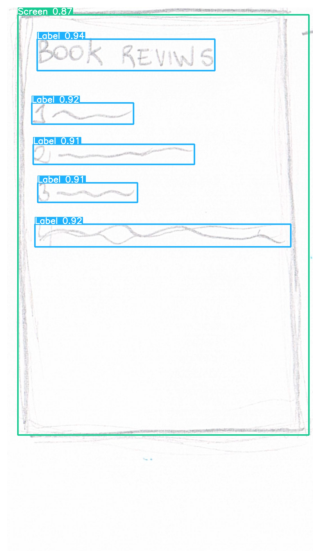

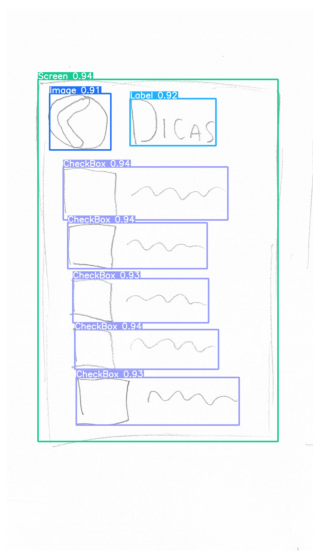

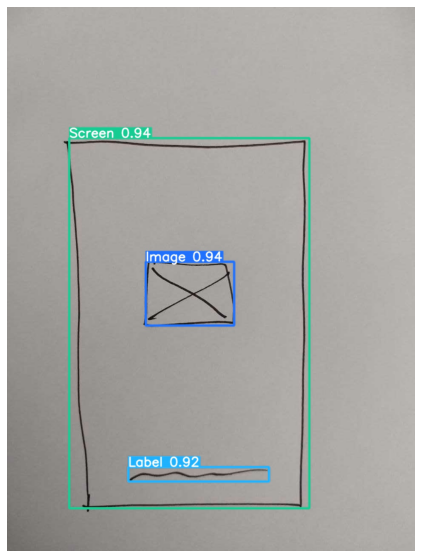

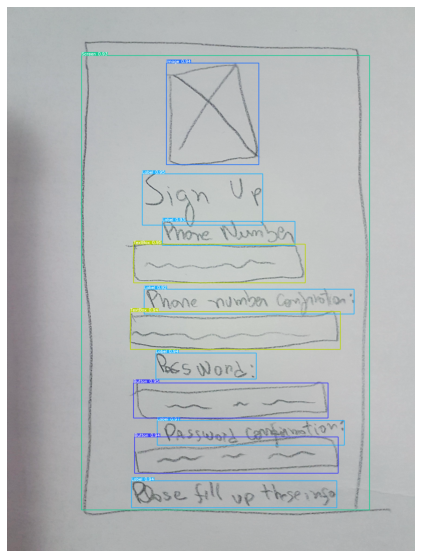

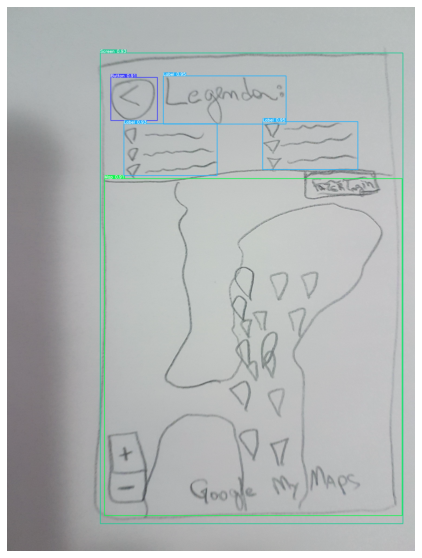

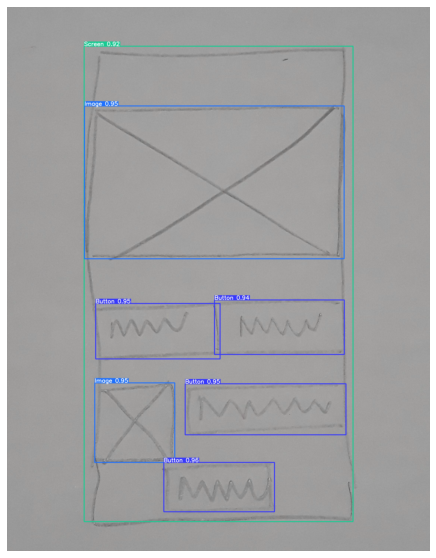

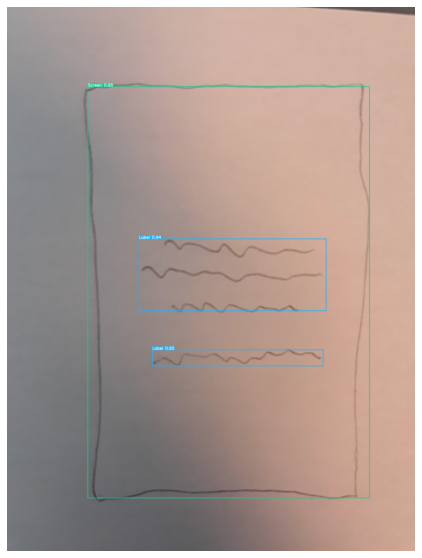

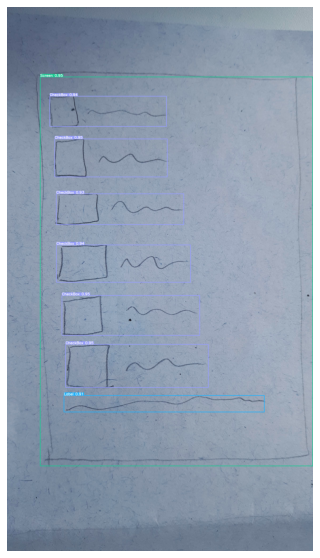

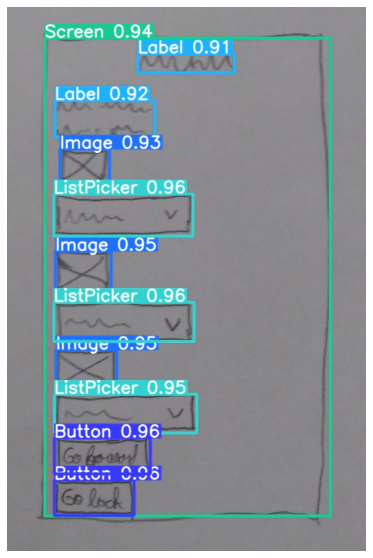

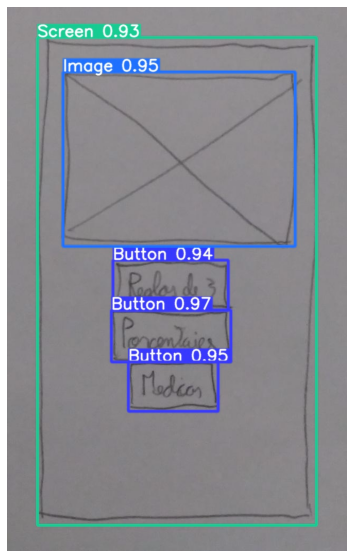

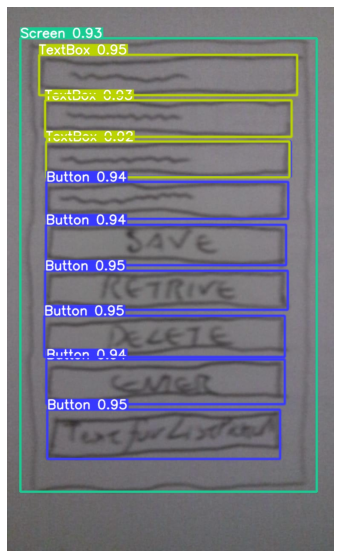

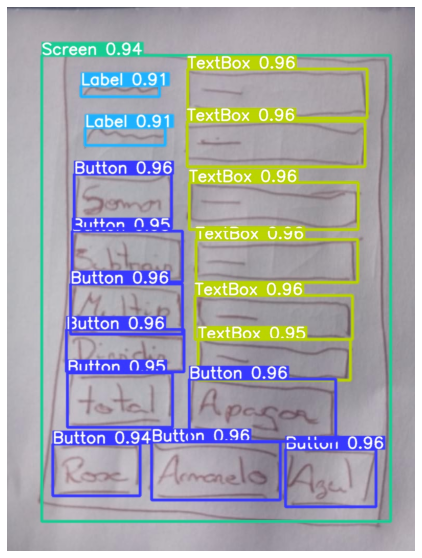

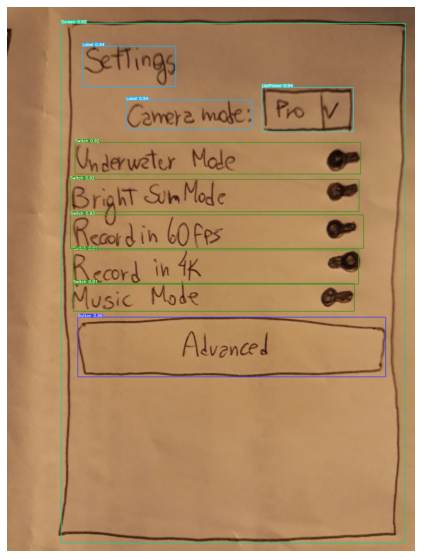

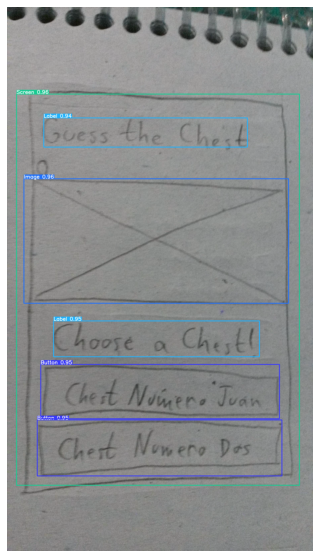

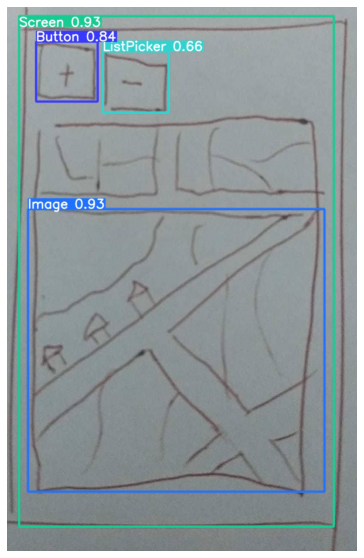

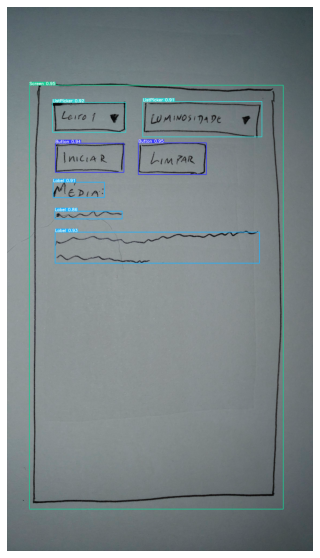

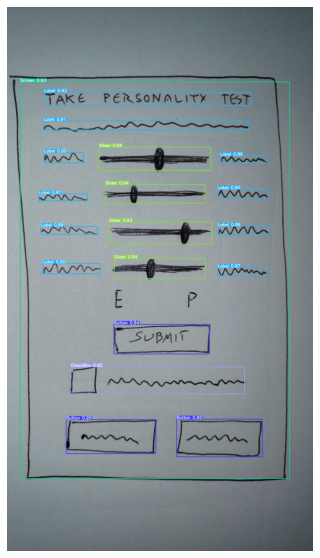

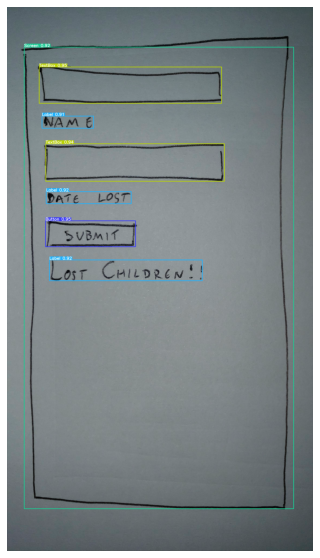

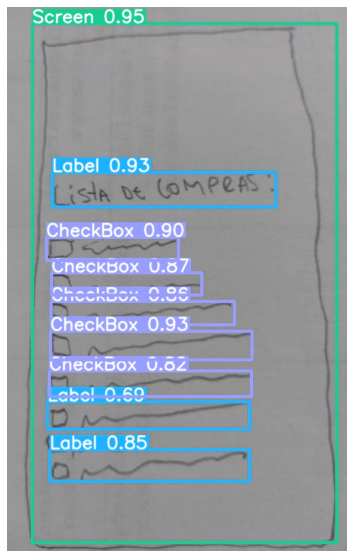

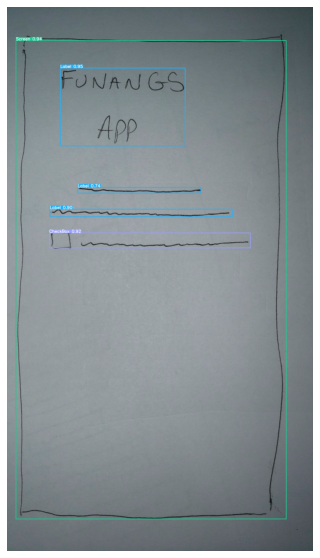

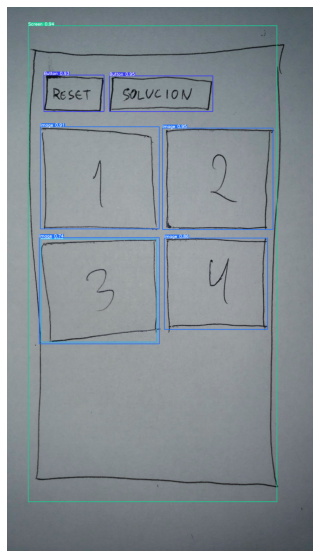

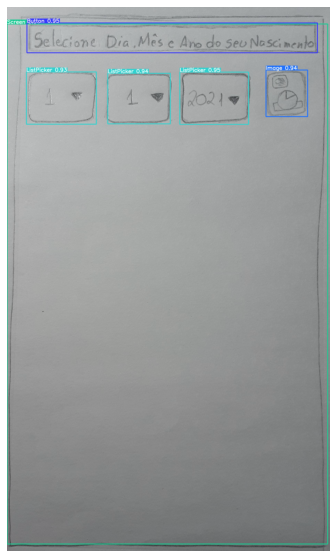

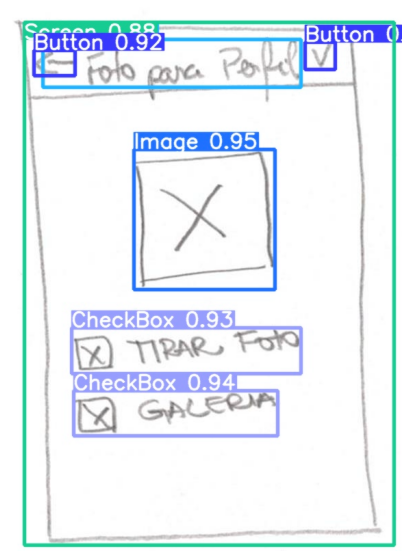

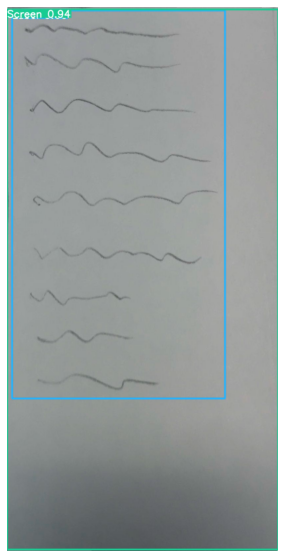

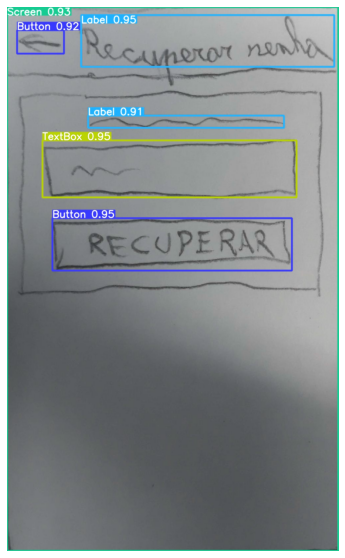

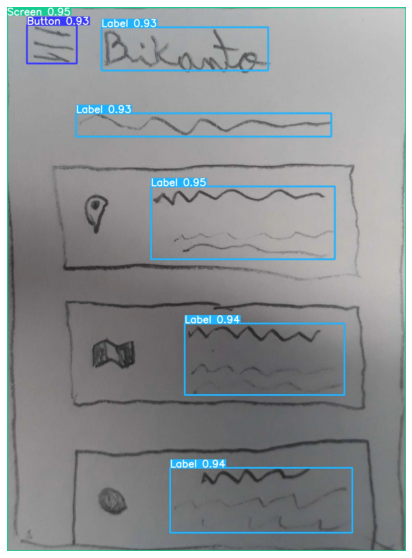

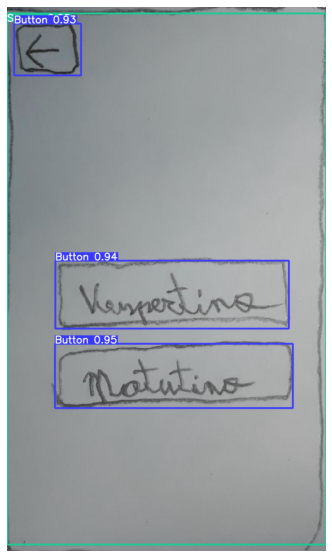

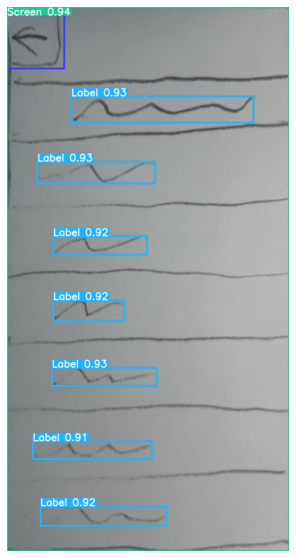

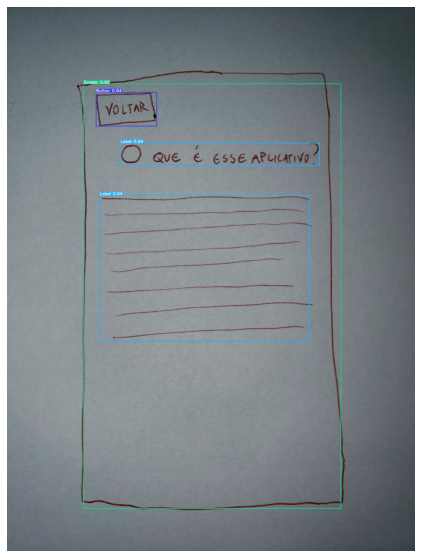

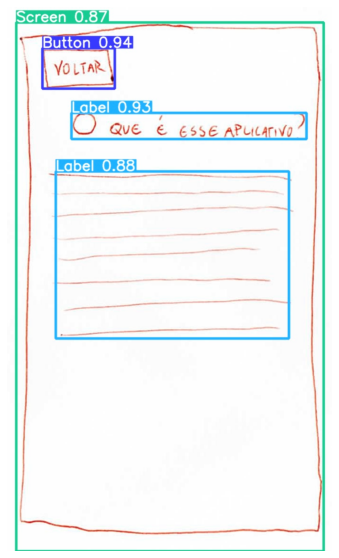

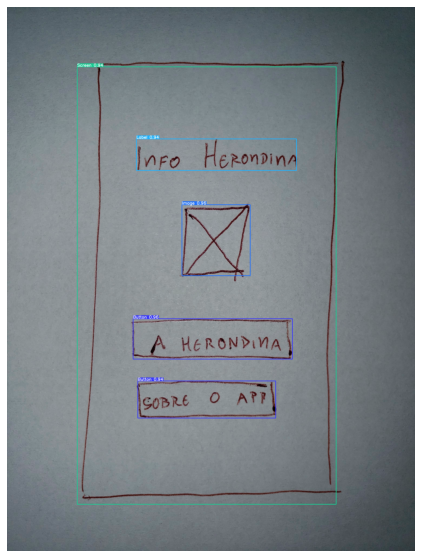

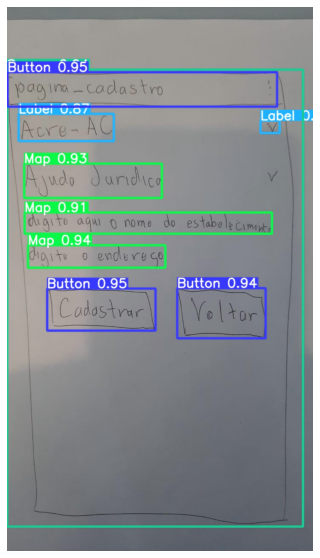

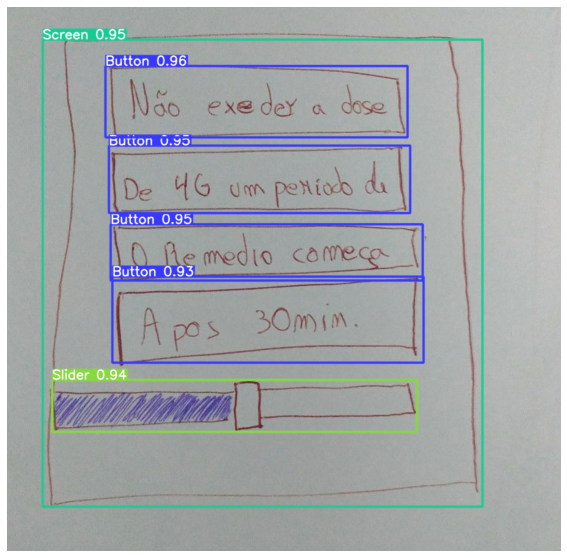

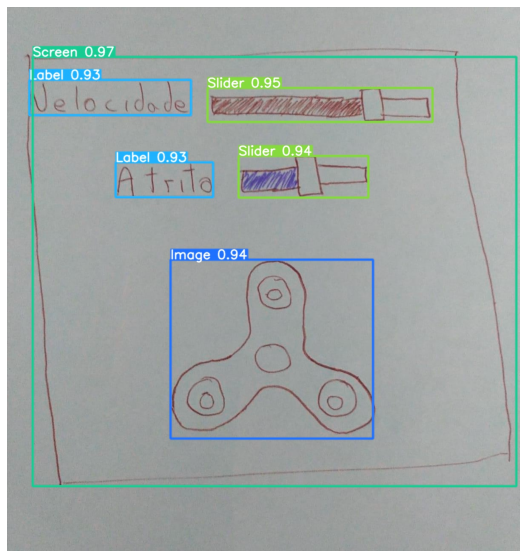

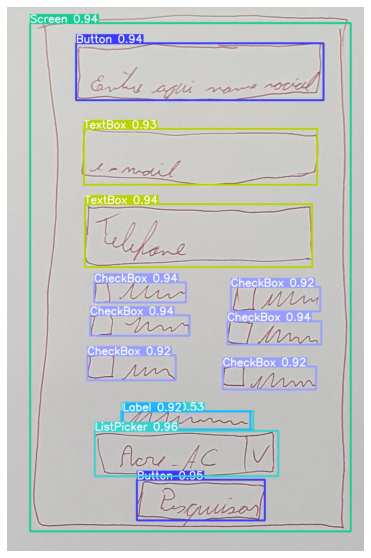

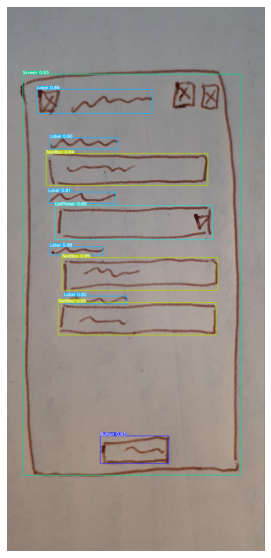

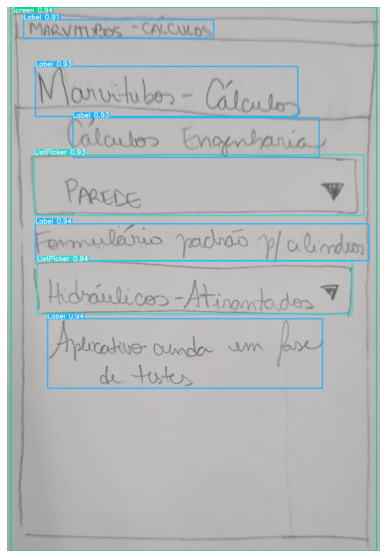

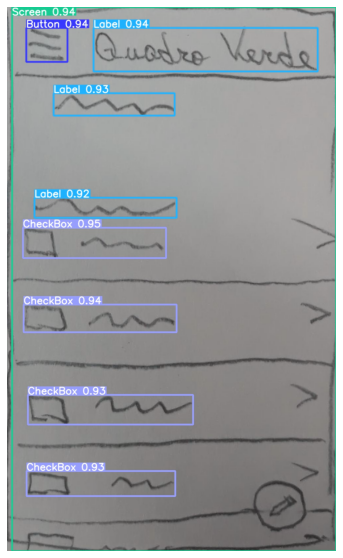

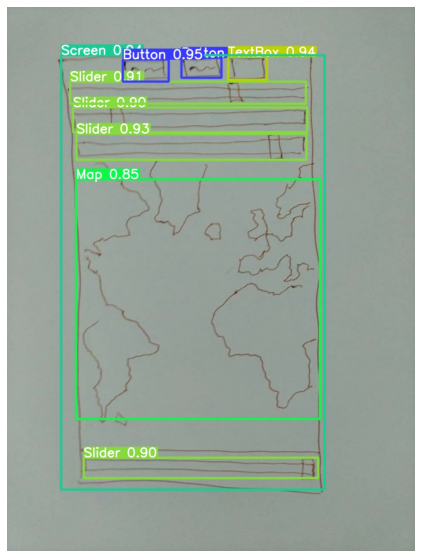

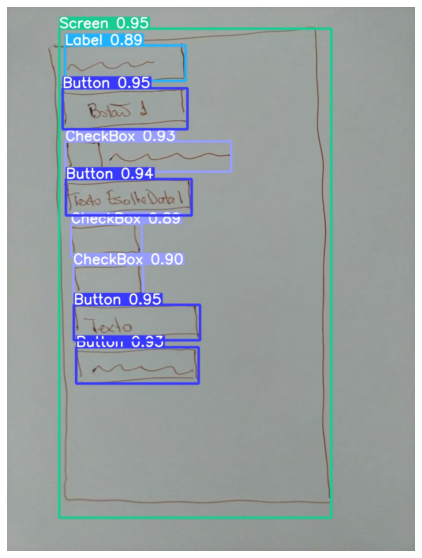

In [13]:
import os
import cv2
import matplotlib.pyplot as plt

results_folder = './runs/detect/exp10'

# Find the preview image
images = [os.path.join(results_folder, file) 
         for file in os.listdir(results_folder) 
         if os.path.splitext(file)[1].lower() in ('.jpg', '.jpeg')
        ]

plt.rcParams['figure.figsize'] = [10, 10]

for image in images:
    fig1, ax = plt.subplots()
    ax.axis('off')
    image = cv2.imread(image)
    ax.imshow(image, cmap=plt.cm.gray)

plt.show()

## Avaliação do Modelo

Métricas do treinamento do modelo podem ser obtidas por meio do Tensorboard:

In [5]:
!python val.py --weights ../yolov5m6/weights/best.pt --data ../CompleteSketchesDataset/data.yaml

val: data=../CompleteSketchesDataset/data.yaml, weights=['../yolov5m6/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs\val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5  v6.1-61-gbc3ed95 torch 1.10.2+cpu CPU

Fusing layers... 
Model summary: 378 layers, 35300868 parameters, 0 gradients, 49.1 GFLOPs

val: Scanning 'C:\Users\dsbau\OneDrive\Documents\UFSC\Mestrado\2oSemestre\INE410121-VisaoComputacional\INE410121-VisaoComputacional\yolov5\..\CompleteSketchesDataset\valid\labels' images and labels...:   0%|          | 0/80 [00:00<?, ?it/s]
val: Scanning 'C:\Users\dsbau\OneDrive\Documents\UFSC\Mestrado\2oSemestre\INE410121-VisaoComputacional\INE410121-VisaoComputacional\yolov5\..\CompleteSketchesDataset\valid\labels' images and labels...1 found, 0 missing, 0 empty, 0 corrupt:   1%|1         | 1/

To view results, fill out the folder where results were saved:

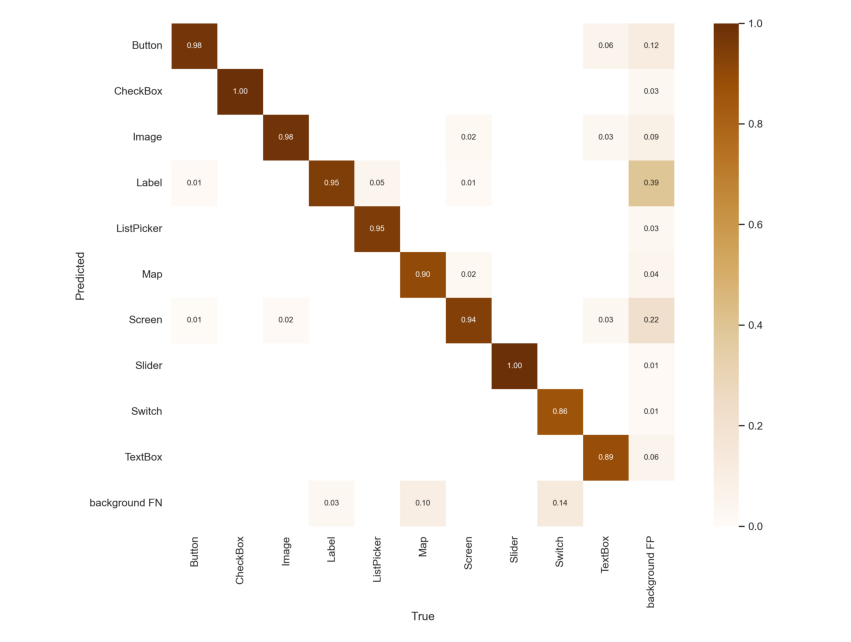

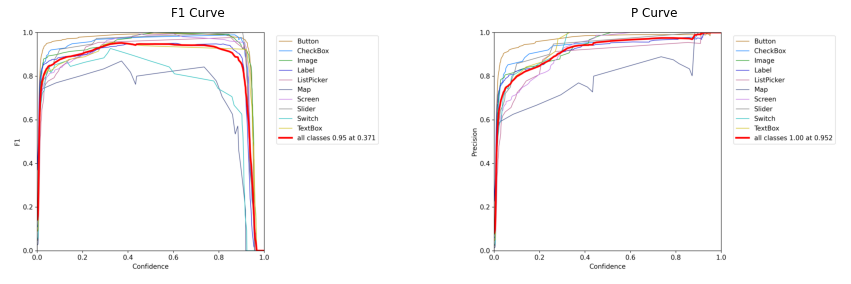

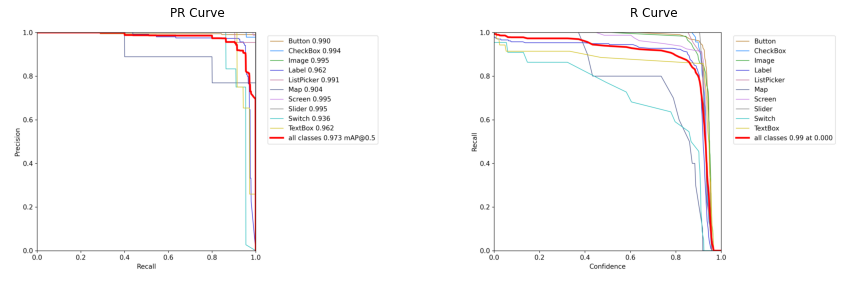

In [28]:
import os
import cv2
import matplotlib.pyplot as plt

results_folder = 'runs/val/exp11'

confusion_matrix_path = os.path.join(results_folder, 'confusion_matrix.png')
f1_curve_path = os.path.join(results_folder, 'F1_curve.png')
p_curve_path = os.path.join(results_folder, 'P_curve.png')
pr_curve_path = os.path.join(results_folder, 'PR_curve.png')
r_curve_path = os.path.join(results_folder, 'R_curve.png')

fig1, ax = plt.subplots()

ax.axis('off')
confusion_matrix = cv2.imread(confusion_matrix_path)
ax.imshow(confusion_matrix, cmap=plt.cm.gray)

fig2, (ax21, ax22) = plt.subplots(1, 2)

f1_curve = cv2.imread(f1_curve_path)
p_curve = cv2.imread(p_curve_path)

ax21.set_title('F1 Curve')
ax21.imshow(f1_curve, cmap=plt.cm.gray)
ax21.axis('off')
ax22.set_title('P Curve')
ax22.imshow(p_curve, cmap=plt.cm.gray)
ax22.axis('off')

fig2, (ax31, ax32) = plt.subplots(1, 2)

pr_curve = cv2.imread(pr_curve_path)
r_curve = cv2.imread(r_curve_path)

ax31.set_title('PR Curve')
ax31.imshow(pr_curve, cmap=plt.cm.gray)
ax31.axis('off')
ax32.set_title('R Curve')
ax32.imshow(r_curve, cmap=plt.cm.gray)
ax32.axis('off')

plt.show()